뉴스 데이터셋을 활용하여 **추상적 요약**과 **추출적 요약**을 진행하겠습니다.

##  사용할 모듈 import

In [1]:
#import nltk
#nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

#from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


import requests   # 추출적 요약
from summa.summarizer import summarize # 추출적 요약


## 데이터 수집하기
사용할 뉴스 기사 데이터 셋 : **[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)**

아래의 코드로 데이터 셋 다운로드 할 수 있습니다.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
78676,Nitish-Lalu alliance was a mismatch: Union Law...,Union Law Minister Ravi Shankar Prasad on Wedn...
33552,Ex-Britannia exec's dairy firm Happy Cow raise...,Mumbai-based dairy startup Happy Cow Dairy has...
70717,McGregor sued for Ã¢ÂÂ¹60 lakh over bottle-th...,UFC champion Conor McGregor has been sued by a...
54766,Pak's spy agency trying to revive Khalistan mo...,Operatives of Pakistan's espionage agency ISI ...
73356,Reliance Jio temporarily suspends JioPhone pre...,Reliance Jio has temporarily suspended pre-boo...
20055,"Got army of brothers, Siddharth's leader by de...",Actress Priyanka Chopra shared a picture with ...
69337,"Star found to spin at 320 km/sec, near to 'bre...",Australia-based scientists have found a star n...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
9570,Apple to delete WhatsApp sticker apps from App...,Apple is planning to delete all WhatsApp stick...
79114,18-month-old Mumbai girl dies after being hit ...,An 18-month-old girl reportedly died on Saturd...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

**추상적 요약**을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 

그리고 **추출적 요약**을 하는 경우에는 text열만 사용하면됩니다.

# 데이터 전처리하기 (추상적 요약)
- 중복 및 NULL값 제거
- 텍스트 정규화 및 정제
- 불용어 제거
- 훈련데이터와 테스트데이터 나누기



### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [5]:


# text_max_len = 40
# -> 0.9 이상print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text열의 경우 중복을 제외한다면  98,360개  , Headlines에는 98,280개의 유일한 데이터가 존재합니다. 여기서 Headlines의 경우 원문 (text)에서의 내용이 달라도 핵심 내용이 같을 순 있기에  Headlines의 경우는 중복이 있을 수 있습니다.

그렇지만, text의 경우 중복이 존재한다면 아예 같은 내용을 말하는 것이기에 text열의 중복 데이터는 제거해야 해요.

데이터프레임의 **`drop_duplicates()`**를 사용하면, 손쉽게 중복 샘플을 제거할 수 있습니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


중복이 제거되면서 샘플 수가 98,360개로 줄어들었습니다. 

그런데 만약 데이터가 **Null**값을 가지는 샘플이 있었다면, **`drop_duplicates()`**가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null값 한개가 어딘가 남아있을 수 있어요. 

데이터에 Null 값이 남아있는지 확인해 봅시다.~


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 0으로 나오는 것을 보니 null 값이 아예 없었던것 같네요.

In [8]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


이렇게 중복, NULL값의 처리를 통해 데이터의 샘플이 총 98,360개가 되었습니다.

### 텍스트 정규화와 불용어 제거
살아남은 98,360개의 샘플에는 수많은 단어들이 있습니다. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.

예를 들어서 'i'll'은 'i will'과 같고, 'mightn't과 'might not'은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법입니다.

이러한 방법론을 텍스트 처리에서는 **`텍스트 정규화(text normalization)`**라고 해요.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성하겠습니다.

### 텍스트 정규화

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


### 불용어(stopwords)
그리고 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 라고 **`불용어(stopwords)`**라고 부릅니다.

때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 **NLTK**에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하겠습니다.

- **NLTK**는 `Natural Language Toolkit`의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리로 문장에는 자주 등장하지만, 의미를 분석하고 요약하는데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어있습니다.

In [10]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/ssac27/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

데이터 전처리기 제대로 되었는지 확인해 봅시다.

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("불용어 제거 o")
print(preprocess_sentence(temp_text))
print("불용어 제거 x")
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

불용어 제거 o
everything bought great infact ordered twice third ordered wasfor mother father
불용어 제거 x
great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, 과 같은 html 태그가 제거되었습니다. 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 

그리고 특수문자가 제거되면서 영어만 남았습니다.

훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, **text의 경우에는 불용어를 제거**하고, **headlines의 경우에는 불용어를 제거**하지 않을 것이므로 따로 호출해서 진행해야 합니다.

In [14]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
# 시간이 오래 걸릴 수 있습니다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

이제 headlines에 대해서 전처리 함수를 호출해줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어주겠습니다.

In [15]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 
# 시간이 오래 걸릴 수 있습니다.
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 **빈(empty)** 샘플이 생겼는지 확인해보는 것이 좋습니다.  
정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 됩니다.

이를 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 다시 저장하고고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체하겠습니다.

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

모든 데이터 샘플들에서 Null값이 생기지 않았습니다.  

---
## 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시 해줘야합니다.

### 샘플의 최대 길이 정하기

필요없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해주겠습니다.

text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보겠습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


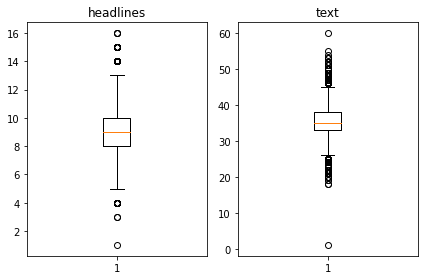

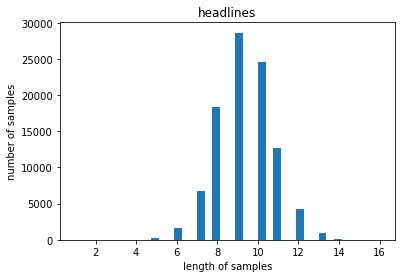

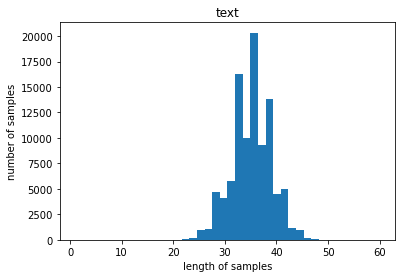

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서 부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 갯수, 실제 텍스트 샘플 길이별 갯수를 나타내고 있어요.

Text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이를 보입니다. 그리고 평균 길이는 35로 시각화 된 그래프로 봤을 때는 대체적으로는 분포가 안정적으로 보입니다.


headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 짧습니다. 

이로부터 Text의 최대 길이와 headlines의 최대 길이를 임의로 정해보겠습니다.

In [19]:
text_max_len = 45

headlines_max_len = 14

text의 최대는 45로 headlines의 경우 14로 정했는데 이 길이를 선택했을 때, 
얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 됩니다. 

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [20]:
def below_threshold_len( max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len) :
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있습니다.

In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123


2개 모두 99이상이니 좀더 범위를 좁혀 봅니다.

In [22]:
text_max_len = 38  # 0.816

headlines_max_len = 10  # 0.816



In [23]:
below_threshold_len( text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


이정도로 맞추고 데이터 정제를 진행하겠습니다.

각각 38과 10으로 패딩을 하게되면 해당 길이보다 긴 샘플들은 내용이 잘리게 됩니다. 

정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하겠습니다.

In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65295


### 시작 토큰과 종료 토큰 추가하기

디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추게 됩니다.

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다.  이 프로젝트에서는 **시작 토큰은 'sostoken'**, **종료 토큰은 'eostoken'**이라 임의로 명명하고 앞, 뒤로 추가하겠습니다. 

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 **decoder_input**,
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 **decoder_target**이라고 이름을 정하겠습니다.

두 개의 문장 모두 headlines 열로부터 만들면 됩니다.

In [25]:
# headlines 데이터에 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장한 후 데이터를 훈련데이터와 테스트 데이터로 분리하겠습니다.

In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

직접 코딩을 통해서 데이터를 분리하겠습니다.  
우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[60598  4782 10171 ... 60162 48070  2454]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 되겠죠.

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해줍니다.

In [30]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13059


이렇게 정의한 테스트 데이터의 갯수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해주세요.

In [31]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


## 정수 인코딩


### 단어 집합(vocaburary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 
각 단어에 고유한 정수로 매핑하는 작업이 필요합니다.

- 우선, 원문에 해당되는 **`encoder_input_train`**에 대해서 단어 집합을 만들겠습니다.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.


### 토큰화

In [32]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 **src_tokenizer.word_index**에 저장되어 있습니다. 이때, 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행합니다.

등장 빈도수가 낮은 단어들을 확인해 보겠습니다. 

- **src_tokenizer.word_counts.items()**에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [33]:
threshold = 8  # 등장 빈도수 지정
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57271
등장 빈도가 7번 이하인 희귀 단어의 수: 40600
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16671
단어 집합에서 희귀 단어의 비율: 70.89102687223901
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.015675750418349


encoder_input_train에는 총 57,271개의 단어가 있네요. 그 아래의 통계 정보들을 해석해 보면,

등장 빈도가 threshold 값인 8회 미만, 즉, 7회 이하인 단어들은 단어 집합에서 70.8% 이상을 차지하네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 5.01%밖에 되지 않아요.

그래서 등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.
위에서 이를 제외한 단어 집합의 크기를 16,671으로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 16,500으로 제한하겠습니다. 
- 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [34]:
src_vocab = 16500
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

**texts_to_sequences()**는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요.
현재 단어 집합의 크기를 16,500으로 제한했으니까 이제 16,500이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않게 됩니다.

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2214, 66, 18, 3232, 601, 47, 101, 729, 5805, 14659, 2639, 1406, 1372, 178, 62, 1372, 1752, 3998, 2162, 78, 225, 7, 3127, 81, 1499, 80, 3, 91, 43, 56, 220, 236, 1790, 336, 413, 232, 167], [4, 179, 133, 564, 93, 373, 69, 9120, 2688, 1972, 12, 52, 175, 40, 52, 6318, 69, 2719, 6910, 4, 186, 1183, 608, 2824, 219, 1542, 429, 3954, 466, 777, 13, 2553, 1760], [120, 156, 487, 1485, 53, 1, 14660, 120, 1226, 1822, 1823, 811, 5178, 1226, 3870, 124, 29, 2, 434, 333, 515, 241, 3, 3642, 6, 286, 2, 6804, 665, 15580, 1273, 1485, 3]]


정수 값으로 잘 변환이 되었네요.

이제 **headlines** 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 **decoder_input_train**을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산합니다.

In [36]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

headlines 데이터도 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되어 있고  **tar_tokenizer.word_index**에 저장되어있어요.  

**tar_tokenizer.word_counts.items()**에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻은 후 등장 빈도수가 4회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [37]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25985
등장 빈도가 4번 이하인 희귀 단어의 수: 16564
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9421
단어 집합에서 희귀 단어의 비율: 63.74446796228593
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.53968059183423


등장 빈도가 4회 이하인 단어들은 단어 집합에서 약 63%를 차지하고있네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 5.53%밖에 되지 않아요. 

이 단어들도 모두 제거하고 단어 집합의 크기를 9,421에서 어림잡아 9,000으로 단어 집합의 크기를 제한하겠습니다.


In [38]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1061, 963, 3600, 48, 2322, 3, 607, 25, 277, 1374], [1, 10, 514, 269, 6, 73, 3224, 4, 77], [1, 2323, 116, 20, 1437, 3, 206, 3225, 798, 946], [1, 2324, 5226, 3, 1391, 2530, 7, 1415, 360], [1, 1819, 54, 3009, 4, 592, 528, 5, 38, 82]]
target
decoder  [[1061, 963, 3600, 48, 2322, 3, 607, 25, 277, 1374, 2], [10, 514, 269, 6, 73, 3224, 4, 77, 2], [2323, 116, 20, 1437, 3, 206, 3225, 798, 946, 2], [2324, 5226, 3, 1391, 2530, 7, 1415, 360, 2], [1819, 54, 3009, 4, 592, 528, 5, 38, 82, 2]]


정상적으로 정수 인코딩 작업이 끝났습니다.

빈도수가 낮은 단어를 제거하면서 빈도수가 낮은 단어로만 구성된 샘플들은 단어가 없는 빈(empty) 샘플이 되었을 가능성이 있어요. 이런 현상은 평균길이가 35였던 **text** 데이터보다 평균 길이가 9인 **headlines**에서 더 두드러졌을 가능성이 높습니다.

**headlines**에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 **`decoder_input`**에는 **`sos_token`** 또는 **`decoder_target`**에는 **`eos_token`**이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올거에요.   

문장의 길이가 0이 된 **`decoder_input`**에는 시작 토큰인 **`sostoken`**, **`decoder_target`**에는 종료 토큰인 **`eostoken`**만 남아 있을테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 **`drop_train`**과 **`drop_test`**에 라는 변수에 저장하고 삭제하겠습니다.

In [39]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


모든 데이터가 토큰 + 제거되지 않은 단어로 구성이 되어 있네요.  
혹시 모르니, 길이가 2 이상인 데이터를 확인해 보겠습니다.

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) >= 2]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) >= 2]

print('삭제하지 않을 훈련 데이터의 개수 :',len(drop_train))
print('삭제하지 않을 테스트 데이터의 개수 :',len(drop_test))

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))

삭제하지 않을 훈련 데이터의 개수 : 52236
삭제하지 않을 테스트 데이터의 개수 : 13059
훈련 데이터의 개수 : 52236
테스트 데이터의 개수 : 13059


2 이상인 데이터와 총 데이터의 개수가 일치하네요.  
여기서 더 추가적인 작업은 하지 않고 다음으로 패딩을 진행하겠습니다.

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야해요. 아까 정해두었던 최대 길이로 패딩해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

이제 학습에 필요한 데이터 전처리가 모두 끝났습니다.

## 모델 설계하기


이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 보겠습니다.

인코더 부분은 모델을 직접 설계하고 디코더는 어텐션 매커니즘을 사용하겠습니다.


In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요.  
hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴론의 갯수라고 이해하면 됩니다.  
- 추가로, 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠.  

- 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내겠습니다.


In [43]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 합니다.

디코더의 출력층은 어텐션 매커니즘으로 사용하겠습니다.

---
#  어텐션 매커니즘 사용 ( 추상적 요약 )
일반적인 seq2seq보다는 어텐션 메커니즘을 적용한 seq2seq를 사용하는 것이 더 나은 성능을 보일 수 있습니다. 

어텐션 메커니즘을 사용하여 seq2seq를 설계해 봅니다.

### 어텐션 매커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻이에요.  여기서는 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 확인하고 어텐션 매커니즘을 사용하겠습니다.

깃허브에 공개되어 있는 어텐션 함수를 다운로드 합니다.
``` python
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
```

In [45]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일합니다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 어텐션 함수로 설계해볼게요.

In [46]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 256)      4224000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 525312      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있습니다.

## 모델 훈련하기

설계한 모델을 가지고 훈련을 진행하겠습니다.

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
205/205 [==============================] - 64s 311ms/step - loss: 6.2916 - val_loss: 5.9249
Epoch 2/50
205/205 [==============================] - 62s 300ms/step - loss: 5.7450 - val_loss: 5.5654
Epoch 3/50
205/205 [==============================] - 61s 300ms/step - loss: 5.3621 - val_loss: 5.2664
Epoch 4/50
205/205 [==============================] - 61s 298ms/step - loss: 5.0643 - val_loss: 5.1010
Epoch 5/50
205/205 [==============================] - 61s 298ms/step - loss: 4.8274 - val_loss: 4.8988
Epoch 6/50
205/205 [==============================] - 61s 299ms/step - loss: 4.6238 - val_loss: 4.7814
Epoch 7/50
205/205 [==============================] - 61s 299ms/step - loss: 4.4422 - val_loss: 4.6365
Epoch 8/50
205/205 [==============================] - 61s 299ms/step - loss: 4.2798 - val_loss: 4.5749
Epoch 9/50
205/205 [==============================] - 61s 300ms/step - loss: 4.1302 - val_loss: 4.4769
Epoch 10/50
205/205 [==============================] - 61s 297ms/step - l

EarlyStopping을 사용해서 **val_loss**가 증가하는 **`patiensce =2`** 2회 관측되면 학습을 조기에 멈추도록 설정했습니다.

20번째 epoch쯤에서 조기종료되네요.

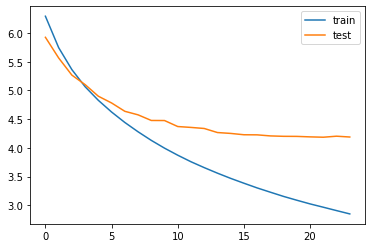

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [49]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계합니다.

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수입니다.

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---
# 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해봅니다.

---
##  모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 만들거에요.

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [67]:
for i in range(30, 40):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actor siddharth tweet addressed bjp wrote dear bjp power empower india stay people private choices stop hindu nation narrative better added row cattle markets unnecessary people centre stay allowing slaughter 
실제 요약 : bjp stop this hindu nation siddharth 
예측 요약 :  bjp should not be in india bjp leader


원문 : cnn news anchor karma ended last bulletin channel friday hoping clear popular wear pants stood audience said us wear trousers see right ended karma signing trousers 
실제 요약 : cnn anchor announces resignation says do wear pants 
예측 요약 :  uk man once turned into white house


원문 : market capitalisation cryptocurrencies would hit trillion mark said powell founder ceo world th largest cryptocurrency exchange volume said cryptocurrency market would continue see growth despite recent price plunge combined market value cryptocurrencies currently billion 
실제 요약 : crypto market will be worth tn this year ceo 
예측 요약 :  bitcoin hits trillion in market capitalisation


원문 : inaugural addre

---
# Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해봅니다.

### summa 데이터 다운

In [55]:
import requests
from summa.summarizer import summarize

summar의 summarize 매트릭스 시놉시스를 다운로드 합니다.

In [56]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

text에는 매트릭스 시놉시스가 문자열로 저장되어져 있어요. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해봅니다.

In [84]:
print(text[:1000])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and 


Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다.  
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요.  
원문의 0.01%만을 출력해도록 설정비율을 주어서 요약문의 문장 개수를 줄여보겠습니다.

In [83]:
print(summarize(text, ratio=0.01))

Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Morpheus, who is above Neo in the walls, breaks through the wall and lands on the agent, yelling to Trinity to get Neo out of the building.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


단어의 수로 요약문의 크기를 조절할 수 있습니다.  

In [87]:
print('summary :')
print(summarize(text, words=60))

summary :
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Morpheus, who is above Neo in the walls, breaks through the wall and lands on the agent, yelling to Trinity to get Neo out of the building.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


문장의 비율의 0.01과 words 60의 요약 문장 내용이 동일하네요.   
이러면 words 60개가 0.01의 비율인 것을 알 수 있게 되었네요.

**Abstractive** 같은 경우 본문의 내용에 없는 단어도 사용이 가능한것을 확인할 수 있습니다.  
그렇지만, 추상적인 내용도 있어서 원문의 직접적인 단어가 들어간 **Extractive Summarization**이 좀 더 핵심을 짚는 능력은 더 좋은것 같습니다.

하지만, **Extractive Summarization**로 할 경우 문장의 길이가 길어야 요약이 제대로 되지만, **Abstractive**로 할 경우 **Extractive**보다 상대적으로 짧아도 문장의 요약이 가능합니다.

In [57]:
# 비율이 0.001로 너무 짧아서 요약이 안됩니다.
print(summarize(text, ratio=0.001))

In [71]:
# 문장을 요약하는데 길이가 많이 필요하다.
# 추출적 요약(Extractive Summarization)
print(len(text))
print(text[:1000])

35932
The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and 

In [72]:
# 긴 문장을 짧은 단어로 추출적 요약하려 하니 내용이 너무 짧게 요약이 되었다.
print(summarize(text, words=10))

Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


추상적 요약(Abstractive Summarization)은 더 짧은 길이에도 요약을 할 수 있습니다.

아래에 첫번째 문장의 경우 필요없는 단어도 있지만 요약된 내용에서 serna가 사진을 공유한다는 내용이 들어가 있어서 괜찮게 요약이 되었음을 알 수 있습니다.

In [70]:
print("원문 :", seq2text(encoder_input_test[11]))
print("실제 요약 :", seq2summary(decoder_input_test[11]))
print("예측 요약 :", decode_sequence(encoder_input_test[11].reshape(1, text_max_len)))

원문 : reacting tennis player serena williams confirming pregnancy former world number one andy tweeted gonna baby goat referred greatest time often used serena player weeks pregnant confirmed pregnancy wednesday posting picture baby bump snapchat 
실제 요약 : be baby goat ex world no on serena pregnancy 
예측 요약 :  serena williams shares picture with serena


이 아래 문장도 요약이 괜찮게 이루어 졌습니다.

In [69]:
print("원문 :", seq2text(encoder_input_test[32]))
print("예측 요약 :", decode_sequence(encoder_input_test[32].reshape(1, text_max_len)))

원문 : market capitalisation cryptocurrencies would hit trillion mark said powell founder ceo world th largest cryptocurrency exchange volume said cryptocurrency market would continue see growth despite recent price plunge combined market value cryptocurrencies currently billion 
예측 요약 :  bitcoin hits trillion in market capitalisation


**추출적 요약**은 보면 주어진 문장에서 뽑아서 요약을 하므로 문장을 해석했을때, 어색하게 문장이 이어지지만,  **추상적 요약**은 문장이 좀 더 부드럽게 이어집니다. 

---

#### 추출적 요약(Extractive Summarization)
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.

- Trinity는 헬리콥터를 Morpheus가있는 바닥으로 내려 가고 Neo는 세 명의 요원에게 발포합니다.


#### 추상적 요약(Abstractive Summarization)
bitcoin hits trillion in market capitalisation
- 비트 코인, 시가 총액 수조에 도달


추출적 요약보다 추상적 요약이 글로만 보았을때는 더 잘 읽히네요.


---

### 회고

- 문장 요약이 네이버의 기사와 같은 요약처럼은 깔끔하고 핵심적인 요약을 쉽게 할 수 있을줄 알았지만, 하다보니 원하는 부분의 요약이 안되는 경우도 있어서 기존의 네이버 기사 3줄 요약이 간단해 보이지만 어렵다는것을 알 게 되었던것 같습니다.


- 하면서 추출적 요약이 확실히 추상적 요약보단 난이도가 쉬워서 좋은것 같지만, 문장의 길이나 input을 받은 문장에서만 요약을할 수 있어서 제한적이라는 생각이 들었습니다.  


- 그리고 프로젝트를 하면서 **추출적 요약**은 내용의 어떤 **편향**적인 요소가 없는 문장 자체의 내용에서 핵심 부분을 보일때 사용하는것이 좋은것 같고 **추상적 요약**은 괜찮은 모델을 만든다면, 사람의 생각이 어느정도 반영된 요약을 흉내낼 수 있을것 같다는 생각이 들었습니다.    
<br>같은 기사가 주어졌을때 IT 부분을 위주로 학습시켜서 어떤 기사의 IT부분을 더 강조해서 요약한다거나 아니면 경제 부분을 더 요약한다거나 하는 등의 방식으로도 할 수 있을것 같아서 여러 생각을 가지고 프로젝트를 할 수 있어서 좋았습니다.